## Assignment 4 - Distributed Kalman Filtering

- **Topic:** Distributed state estimation of a target
- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:** 28-03-2025, 17:00
- **Submitting: SUBMIT ONLY `assignment4_groupNumber.ipynb` TO BRIGHTSPACE**. 
where groupNumber is your group number.



### Instructions
**Installation:** The implementation is tested with python 3.9.21 and packages including
-   numpy version: 2.0.2
-   matplotlib version: 3.9.4


Other (not too old or new) versions will probably also work.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file.
Please do not change the additional files `helper.py` and `linAlg.py`, and the dictionary `model_parameters` as this might result in breaking the assignment.


### AI Related Policy
We strongly discourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.

### Personal Information
Please fill in your names and student numbers in the cell below.

In [ ]:
# YOUR ANSWER HERE
STUDENT_1_NAME = "Tom Lijding"
STUDENT_1_STUDENT_NUMBER = "6318037"

STUDENT_2_NAME = "Tjalle Aalbers"
STUDENT_2_STUDENT_NUMBER = "5374774"

### Description and Objectives

The primary objective of this assignment is to estimate the position of a maneuvering target in 2D using a network of anchors. The target is traveling along an unknown trajectory in two dimensions, within the sensing range of the anchors, which have fixed positions. The anchors can measure the radial distance between themselves and the target throughout its journey, with some noise.

We consider a scenario similar to (but not identical to) the figure shown below. In the figure, a network of fixed-position anchors (blue circles) measures the radial distances (red circles) between themselves and the target (represented as a purple triangle). To estimate the target's position the anchors need to communicate with one another, however, they are only allowed to interact with their immediate neighbors in the network as indicated by the gray dashed lines.

The main focus will be to collaboratively estimate the target's position using distributed state estimation, by implementing a distributed Kalman filter formulation.
\
![alt text](multiagent_tracking.png "Title") 

Each anchor is denoted by an integer $n \in \{1, 2, \dots, N\}$ where $N$ is the number of anchors in the network. 
At each time step $k$, anchors measure the squared distance $(d_k^n)^2 \in \mathbb{R}^+$ between their (fixed) positions $\mathbf{p}^n \in \mathbb{R}^2$ and the target position $\mathbf{p}_k \in \mathbb{R}^2$ as
$$
    d_k^n \triangleq ||\mathbf{p}^n - \mathbf{p}_k ||_2.
$$
Unfortunately the measurement model is nonlinear and not suitable for a standard Kalman filter in this form.
We can however, tweak this formulation to obtain a linear form by squaring the distance and expanding the squared norm as
\begin{aligned}
    (d_k^n)^2 &=  ||\mathbf{p}^n - \mathbf{p}_k ||_2^2 = (\mathbf{p}^n - \mathbf{p}_k)^T (\mathbf{p}^n - \mathbf{p}_k), \\
              &= (\mathbf{p}^n)^T \mathbf{p}^n - 2 (\mathbf{p}^n)^T \mathbf{p}_k + \mathbf{p}_k^T \mathbf{p}_k, \\
    (d_k^n)^2 - (\mathbf{p}^n)^T \mathbf{p}^n &= - 2 (\mathbf{p}^n)^T \mathbf{p}_k + \mathbf{p}_k^T \mathbf{p}_k, \\
    y_k^n &= \tilde{\mathbf{H}}^n \tilde{\mathbf{p}}_k,
\end{aligned}
where $y_k^n \triangleq (d_k^n)^2 - ||\mathbf{p}^n||_2^2, \quad  \tilde{\mathbf{H}}^n \triangleq \begin{bmatrix}  - 2 (\mathbf{p}^n)^T  &  1 \end{bmatrix}, \quad  \tilde{\mathbf{p}}_k \triangleq  \begin{bmatrix} \mathbf{p}_k^T & ||\mathbf{p}_k||_2^2 \end{bmatrix}^T$.
Notice that we added $||\mathbf{p}_k||_2^2$ as a state variable to make this measurement model linear.

To use this approach, let us define the state vector of the target as 
$$ 
\mathbf{x}_k \triangleq \begin{bmatrix} \mathbf{p}_k^T & \dot{\mathbf{p}}_k^T &  ||\mathbf{p}_k||_2^2 \end{bmatrix}^T,
$$
where $ \dot{\mathbf{p}}_k \in \mathbb{R}^2 $ represents the velocity vector.
We can now formulate a state space model to use it for state estimation. 
Denote the state space equations as
\begin{aligned}
    \mathbf{x}_{k+1} &= \mathbf{F} \mathbf{x}_k + \mathbf{w}, \quad \mathbf{w} \sim \mathcal{N}(0, \mathbf{Q}), \\
    y_k^n &= \mathbf{H}^n \mathbf{x}_k + v, \quad v \sim \mathcal{N}(0, R),
\end{aligned}
where we choose the dynamic model matrix $\mathbf{F}$ and $\mathbf{H}^n$ as
\begin{aligned}
    \mathbf{F} &\triangleq \text{blkdiag} \biggl( \begin{bmatrix} 1 & \Delta t_k \\ 0 & 1 \end{bmatrix} \otimes \mathbb{I}_2, 1 \biggr), \\
    \mathbf{H}^n &\triangleq \begin{bmatrix}  - 2 (\mathbf{p}^n)^T & 0 & 0 & 1 \end{bmatrix}, \\
\end{aligned}
and $ \Delta t_k $ is the time difference between time step $k+1$ and $k$.

### Provided data
First let us load the simulated data, the data consists of the following elements
- `dt` $\in \mathbb{R}^+$ (float): Time difference between consecutive time steps
- `T` $\in \mathbb{N}$ (int): Number of time steps
- `edge_list` (list of tuples): Stores the edges as `(i,j)` which denotes the connection between anchors `i` and `j`.
- `anchor_positions` $\in \mathbb{R}^{2 \times N}$ (numpy array): Horizontally stacked anchor position vectors $[\mathbf{p}^1, \ \mathbf{p}^2, \ \dots, \mathbf{p}^N]$ 
- `measurement_list` $\in \mathbb{R}^{N \times T}$ (numpy array): List of measurements $y_k^n$ where `measurement_list[n, k]` denotes the measurement of anchor `n` at time step `k`.
- `true_positions` $\in \mathbb{R}^{2 \times T}$ (numpy array): Horizontally stacked true positions of the target $[\mathbf{p}_1, \ \mathbf{p}_2, \ \dots, \mathbf{p}_T]$ 

After we load the data, let us see what the anchor network, the ground truth trajectory and measurements look like. Note that the measurements plotted as two dimensional points just for clarity. Actual measurements look more like circles since we only measure the radial distances.

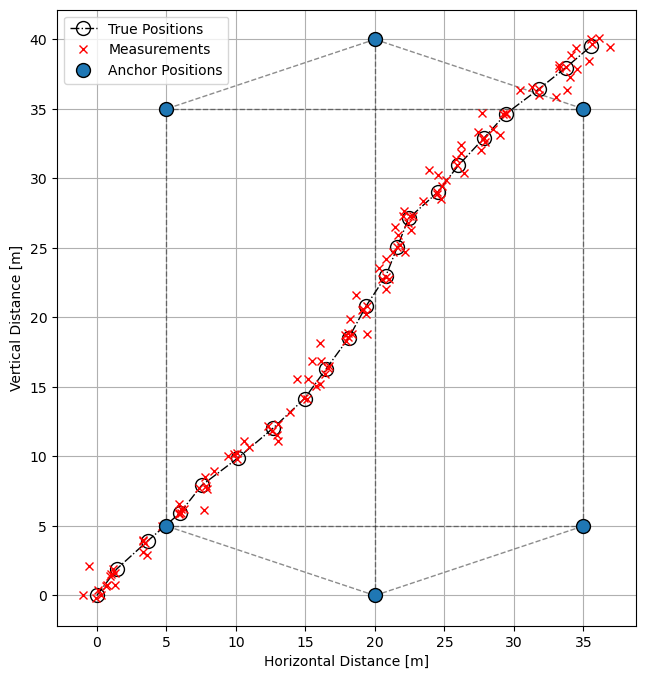

[[0 1]
 [1 2]
 [2 3]
 [3 0]
 [4 1]
 [4 0]
 [5 4]
 [5 2]
 [5 3]]
[[ 5. 35. 35.  5. 20. 20.]
 [ 5.  5. 35. 35.  0. 40.]]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import linAlg
from linAlg import block_diag
import helper as helper

plt.rcParams.update(
    {
        "lines.linewidth": 1.0,
        "lines.markersize": 10,
        "lines.markeredgewidth": 1.0
        
    }
)
measurement_list, true_states, anchor_positions, edge_list, dt, T, model_parameters = helper.initializeDKFAssignment()

helper.plotMeasurementsAndGroundTruth(true_states, anchor_positions, edge_list, model_parameters)
print(edge_list)
print(anchor_positions)

### Task 1: Construct Matrices
Construct dynamic model matrix $\mathbf{F}$ and measurement model matrices $\mathbf{H}^n$ as described above. 
You can use the parameters `initial_mean` vector,`initial_covariance` matrix, process covariance matrix `Q` and measurement noise variance `R` provided below for the rest of the assignment. 
You can use `block_diag` function to construct $\mathbf{F}$.


### Analysis:
Elaborate on the following:
- Why do we add the new variable $||\mathbf{p}_k||_2^2$ to the state vector? If we wanted to avoid doing this, how would you proceed? 
- Comment on the dynamic update model of the state variable $||\mathbf{p}_k||_2^2$. Does it properly represent the true dynamics? If not, what can be done to mitigate its drawbacks?

### Analysis answers
- In adding the variable $||\mathbf{p}_k||_2^2$ we incorporate the entire measurement model. The problem with the entire measurement model is that there as some nonlinearities. We cannot in fact construct our H matrix if we were to just use $p_k$ as one of our variables since we need to model it's square. If we wanted to avoid this we could take the linearization of H around a point at each time instant and update H for each time step, using the previous best estimate of p as this linearization point (perhaps the Kalman filter future prediciton of p?). Another way of doing this would be to model $||\mathbf{p}_k||_2^2$ as an external disturbance which we have perfect knowledge of at each time instant (we calculate by squaring p)
- Of course, the dynamic update model of the state variable $||\mathbf{p}_k||_2^2$ does not represent the true dynamics. These are of course nonlinear and by choosing Q to be large (we say that we do not believe in our dynamic model a lot) we can "model" our unknown dynamics via Gaussian noise!

In [ ]:
#####  YOUR CODE HERE #####
# We first create the F matrix via the Kronecker product, then we create the H matrix by iterating over the amount of anchors and 
eye2 = np.eye(2)
Fmini = np.array([[1, dt],[0, 1]])
F = block_diag(np.kron(Fmini,eye2),1)
print(Fmini)
print(F)
Nmeas = anchor_positions.shape[1]
Nstates = 5
H = np.empty((Nmeas,Nstates))
for measurement in range(Nmeas):
    H[measurement, :] = np.array([-2*anchor_positions[0, measurement],  # x position
                                 -2*anchor_positions[1, measurement],  # y position
                                 0,  # z position (zeroed out)
                                 0,  # placeholder
                                 1])  # homogeneous coordinate
##### END HERE #####

# Initial Mean and covariance
initial_estimate = np.zeros((5,1))
initial_covariance = np.eye(initial_estimate.shape[0])*100.0

[[1. 1.]
 [0. 1.]]
[[1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
1.0


### Task 2: Centralized Kalman Filter Implementation
Implement a centralized version of the Kalman filter by using all measurements generated by the anchors to update the state estimate. After each time step, append your mean and covariance estimates to lists `centralized_means` and `centralized_covariances` respectively.

Note that for the centralized measurement update version you can use an augmented measurement model in the form
\begin{aligned}
    \begin{bmatrix} y_k^1 \\  y_k^2 \\ ... \\  y_k^N \end{bmatrix} &= \begin{bmatrix} \mathbf{H}^1 \\  \mathbf{H}^2 \\ ... \\  \mathbf{H}^N   \end{bmatrix}  \mathbf{x}_k + \mathbf{v}, \quad \mathbf{v} \sim \mathcal{N}(0, R \ \mathbb{I}_N).
\end{aligned}

### Analysis:
Elaborate on the following:
- Comment on the centralized Kalman filter mean estimates. Explain how $||\mathbf{p}_k||_2^2$ is estimated without even measuring the variable itself.

The estimates are quite good! As stated before, $||\mathbf{p}_k||_2^2$ is estimated via it's linear effect on our measurements. By taking the covariance of our model as very large (for $||\mathbf{p}_k||_2^2$), we are basically saying we do not trust the model at all! Any measurements we make (of the distance to the anchor points) therefore says something about the norm of the distance and we can build it back purely from the measurements. Our Kalman gain will correspondingly update the estimate of the norm of the position a lot more aggresively and we see this when we print the values of the Kalman gain matrix as well, in that the bottom row has much higher values than the first two rows. Of course, the middle rows have only zeros since we cannot measure the velocities.

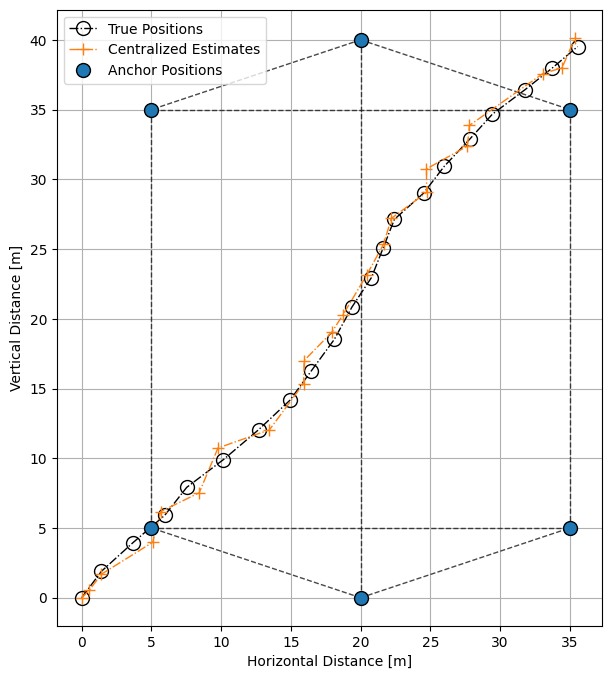

In [4]:
# Centralized estimates
centralized_means = [initial_estimate]
centralized_covariances = [initial_covariance]


#####  YOUR CODE HERE #####
def predStep(sigma_km1_km1,Q,theta_hat_km1_km1):
    theta_hat_k_km1 = F@theta_hat_km1_km1
    sigma_k_km1 = F@sigma_km1_km1@F.T+Q
    return theta_hat_k_km1, sigma_k_km1

def corrStep(sigma_k_km1,R,y_k,theta_k_km1):
    S_k = R + H@sigma_k_km1@H.T
    K_k = sigma_k_km1@H.T@ np.linalg.inv(S_k)
    theta_k_k = theta_k_km1+K_k@(y_k - H@theta_k_km1)
    sigma_k_k = sigma_k_km1 - K_k@H@sigma_k_km1
    return theta_k_k, sigma_k_k

# Initialization
model_parameters['NtimeSteps'] = measurement_list.shape[1]
model_parameters['NtimeStep'] = 0
# position_estimate = np.zeros((Nstates,model_parameters['NtimeSteps']))
# position_covariance = np.zeros((Nstates,Nstates,model_parameters['NtimeSteps']))

def kalmanFilter(position_estimate,Q,R,pos_covariance,model_parameters,measurement):

    if model_parameters['NtimeStep'] > 0:
        ''' Dynamic update '''
        (position_estimate, pos_covariance) = predStep(pos_covariance,Q,position_estimate)  

    ''' Measurement update '''
    (position_estimate, pos_covariance) = corrStep(pos_covariance,R,measurement,position_estimate)

    return position_estimate, pos_covariance


# Process noise covariance (Q) and Measurement noise covariance (R)
# Iteration 0
# Q = np.diag([1.5, 0.15, 1.5, 0.15, 100.0])
# R = 0.75
Q = np.diag([1.5, 0.15, 1.5, 0.15, 100.0])
R = 0.75

bigR = block_diag(R,R,R,R,R,R)


position_estimate = initial_estimate
position_covariance = initial_covariance

for timeindx in range(model_parameters['NtimeSteps']):
    (position_estimate,position_covariance) = kalmanFilter(position_estimate,Q,bigR,position_covariance,model_parameters,measurement_list[:,timeindx:timeindx+1])
    centralized_means.append(position_estimate)
    centralized_covariances.append(position_covariance)
    model_parameters['NtimeStep'] += 1
##### END HERE #####


helper.plotCentralizedKFEstimate(true_states, anchor_positions, edge_list, centralized_means)


### Task 3: Distributed Kalman Filter Implementation
Implement a distributed Kalman filter using the formulation given below. After each time step, append your mean and covariance estimates for anchor `n` to lists `local_means[n]` and `centralized_covariances[n]` respectively.




Assume that anchor $n$ has access to measurements of itself and its neighbors $j \in \mathcal{N}_n \cup \{n\}$.
At time $k$, a local estimate can be computed using the following procedure:

\begin{aligned}
&\text{Time Update:} \\
&\hat{x}_{n, k+1 | k} = F \hat{x}_{n, k+1 | k}  \\
&P_{n, k+1 | k} = F P_{n, k+1 | k} F^T + Q  \\
\newline
&\text{Measurement Update:} \\
&x_{n,k} = \hat{x}_{n, k | k-1} \\
&P_{n,k} = P_{n, k | k-1} \\
&\text{For each} \ j \in \mathcal{N}_n \ \text{repeat:} \\
& \quad S_{j,k} = H_{j} P_{n,k} H_{j}^T + R_{j} \\
& \quad K_{j,k} = P_{n,k} H_{j}^T S_{j,k}^{-1} \\
& \quad x_{n,k} = x_{n,k} + K_{j,k} (y_{j,k} - H_{j} x_{n,k})\\
& \quad P_{n,k} = P_{n,k} - K_{j,k}  H_{j}  P_{n,k} \\
&\text{end} \\
&\hat{x}_{n, k | k} = x_{n,k} \\
&P_{n, k | k} = P_{n,k} \\
\end{aligned}

Alternatively a more compact from  can be expressed, similar to the information form KF, as
\begin{aligned}
&\text{Time Update:} \\
&\hat{x}_{n, k+1 | k} = F \hat{x}_{n, k | k}  \\
&P_{n, k+1 | k} = F P_{n, k | k} F^T + Q  \\
\newline
&\text{Measurement Update:} \\
&P_{n,k | k}^{-1} = P_{n,k | k-1}^{-1} + \sum_{j \in \mathcal{N}_n \cup \{n\}} H_{j}^T  R_{j}^{-1}  H_{j}  \\
&\hat{x}_{n, k | k} = \hat{x}_{n,k | k-1} + P_{n,k|k} \sum_{j \in \mathcal{N}_n \cup \{n\}} H_{j}^T R_{j}^{-1} (y_{j, k} - H_{j}\hat{x}_{n,k | k-1}  )\\
\end{aligned}

### Analysis:
Elaborate on the following:
- Analyze the behavior of the decentralized Kalman filter. At a glance, how does it differ from the centralized one?
- How would the estimates change if you change the number of edges. Comment on what would happen if all edges were removed.
- How many neighbors does an anchor need for a feasible solution? In other words, how many neighbors are required for each anchor to estimate a position? You may provide a geometric interpretation.

- The centralized Kalman filter has a smoother and more accurate trajectory. It stays tightly aligned with the ground truth. The decentralized Kalman filter varies per anchor. Some follow the trajectory pretty well where others tend to deviate more from the ground truth. It can also be seen that when outside the anchor network (outside the grey lines), we observe increased estimation errors compared to the trajectory in the middle of the network. This is caused by a poor measurement geometry. In the beginning and at the end some anchors are in the same general direction resulting in poor conditions and higher uncertainties. When in the middle of the network, the measurement geometry is rich and thus the results are better.
- When adding more edges, the information spreads more effectively. Each node can give more accurate updates due to the presence of more data. When all edges would be removed all anchors would only rely on its own measurements which could be noisy. The performance would drop significantly as each anchor would overfit on its own local measurements leading to inconsistent and inaccurate estimates. Additionally, if all other edges were removed what we in fact have is just a regular Kalman filter but that we can only estimate the distance to our agent. In that case we would have very bad performance, as having just radial distance information is very ambiguous for the actual position.
- In 2D, to estimate a position, an anchor would at least need three independent measurements as this allows the anchor to perform triangulation. When relying on two measurments, this creates two circles which intersect at two points. When adding a third measurement, they intersect at one point leading to an unique solution. When only relying on one measurement, the estimate could be anywhere on the cirlce around the anchor leading to an infeasable solution.

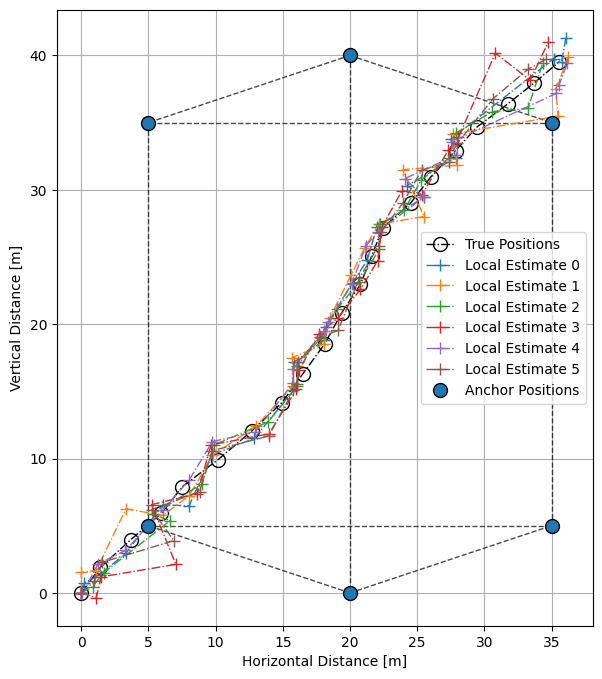

In [ ]:
# Initialize anchor-specific variables
local_means = [[initial_estimate] for _ in range(anchor_positions.shape[1])]
local_covariances = [[initial_covariance] for _ in range(anchor_positions.shape[1])]

#### YOUR CODE HERE ####
N = anchor_positions.shape[1]
T = measurement_list.shape[1]

for k in range(T):
    for n in range(N):

        position_estimate = local_means[n][-1]
        pos_covariance = local_covariances[n][-1]

        #Dynamic update
        if k > 0:
            (position_estimate, pos_covariance) = predStep(pos_covariance,Q,position_estimate)  

        # neighbor list
        neighbors = [n]
        for i in range(edge_list.shape[0]):
            if edge_list[i,0] == n:
                neighbors.append(edge_list[i,1])
            elif edge_list[i,1] == n:
                neighbors.append(edge_list[i,0])

        H_sum = np.zeros((5, 5))
        y_sum = np.zeros((5, 1))    
        for j in neighbors:
            p_j = anchor_positions[:, j:j+1]
            H_j = np.hstack([-2 * p_j.T, np.zeros((1,2)), np.ones((1,1))])
            y_j = measurement_list[j, k]
            residual = y_j - H_j @ position_estimate
            H_sum += H_j.T @ H_j / R
            y_sum += H_j.T * residual / R
    
        # measurement update
        P_post_inv = np.linalg.inv(pos_covariance) + H_sum
        P_post = np.linalg.inv(P_post_inv)
        x_post = position_estimate + P_post @ y_sum

        local_means[n].append(x_post)
        local_covariances[n].append(P_post)

#### END HERE ####

helper.plotDecentralizedKFEstimate(true_states, anchor_positions, edge_list, local_means)

### Task 4: Comparison
Compute the squared errors of the centralized and local position mean estimates and plot them against time instances. Make sure that the axes are labeled with appropriate units. Also include a legend with descriptive names for each estimate.

### Analysis:
- Compare and discuss the filter performances. 
- What are the main advantages and disadvantages of centralized and decentralized Kalman filters?

- When looking at the plot it can be seen that in the beginning there is a spike in the errors which is caused by the position being outside the grey dotted anchor network. The error then drops when inside the area and later significantly rises  when leaving the area. It can also be seen that the results vary between anchors. Anchor three seems to perform the worst out of all the anchors. The spikes at t = 2s mainly consists of anchor 2,3 and 5 where the spike at t = 18s mainly consists of anchors 0, 3 and 4. This is probably caused by the anchor postion and the distance between the anchor and the estimate position. The centralized Kalman filter estimate always has a reasonable error following the general trend of the decentralized Kalman filter. We can further see that some local measurements perform badly when outside of the anchor polygon. If one imagines circles, which define the possible positions of the robot after a measurement (assuming no noise for now), if we measure at the other side of our grid, a big change in the position (radially) corresponds to a quite small change in the measurement, thus we are quite unsure about our measurement because big noise has a small effect on our measurements, and thus the position estimates perform badly when looking at a local Kalman measurement at the other side of the grid. We see that this is not the case for the centralized case, or for local Kalman filters close to the actual position.
- We can think of two reasons for the poor performance near nodes $0$ and $2$. The first reason being that if a measurement is taken close the a node, the angles between measurements far away from the node can become very acute, and thus make the measurements from the far away nodes quite ambiguous. The second reason being that if the the measurements are not taken within the convex hull defined by the points which can make measurements, the geometry is less favorable for measurements and thus noise can lead more quickly to ambiguous positions,leading to worse measurements.
- When looking at accuracy the centralized Kalman filter, as expected, peforms better than any local Kalman filter. This makes sense as we are using more measurements (which are all relatively accurate). Despite this, the centralized Kalman filter is not robust. When the central processor for the centralized Kalman filter fails, the whole filter fails whereas the decentralized Kalman filter is more robust to failures. The centralized Kalman filter may take longer then the decentralized Kalman filter due to delays in the central collection of the data. A centralized Kalman filter is easier to implement then a decentralized Kalman filter.

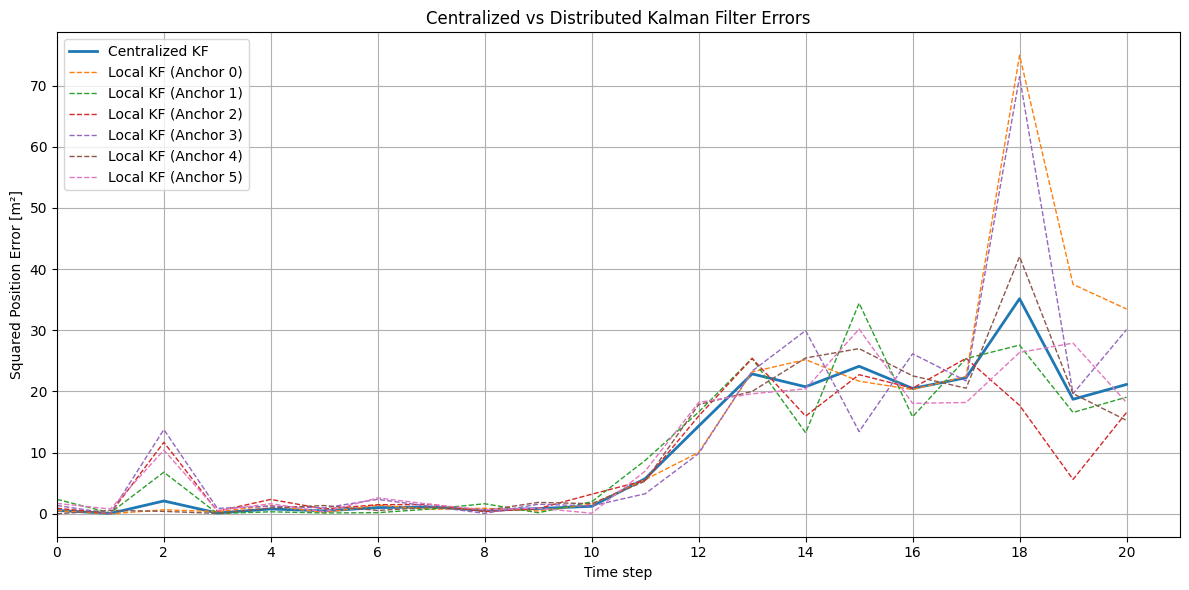

In [ ]:
#### YOUR CODE HERE ####
import matplotlib.pyplot as plt
import numpy as np

def extract_positions(state_list):
    return np.array([x[:2].flatten() for x in state_list])

true_positions = true_states.T

centralized_positions = extract_positions(centralized_means[1:])
centralized_sq_errors = np.sum((centralized_positions - true_positions[:,0:1]) ** 2, axis=1)

distributed_sq_errors = []
for n in range(anchor_positions.shape[1]):
    local_positions = extract_positions(local_means[n][1:])
    sq_error = np.sum((local_positions - true_positions[:,0:1]) ** 2, axis=1)
    distributed_sq_errors.append(sq_error)

# --- Plot ---
time = np.arange(true_positions.shape[0]) * dt  

plt.figure(figsize=(12,6))
plt.plot(time, centralized_sq_errors, label="Centralized KF", linewidth=2)

for n, err in enumerate(distributed_sq_errors):
    plt.plot(time, err, linestyle='--', label=f"Local KF (Anchor {n})")

plt.xlabel("Time step")
plt.ylabel("Squared Position Error [m²]")
plt.title("Centralized vs Distributed Kalman Filter Errors")
plt.legend()
plt.xlim(0, 21)
plt.xticks(np.arange(0, 21, 2))
plt.grid(True)
plt.tight_layout()
plt.show()


#### END HERE ####

#### Feedback:
This is the first year we are teaching this course. Your feedback will be invaluable in improving it for the coming years. Please let us know in this markdown any comments, suggestions or errors you have encountered in the last three assignments.

The assignments are nice! Enjoyable, well made and thought out. The visualizations are nice and illustrate well how the systems evolve dynamically and how changes in covariances, length scales etc. effect the filters. Perhaps a more theoretical background would be nice to have during the assignment as it is quite easy to complete the assignments by just scanning the slides. I can imagine a lot of students may not perform that well during the oral since they believe that they are performing well during the assignments but they do not have a good theoretical grasp on the techniques!